<a href="https://colab.research.google.com/github/MarkoHaralovic/DL_cyber_attacks/blob/main/notebooks/data_poisoning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torchvision
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import random

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


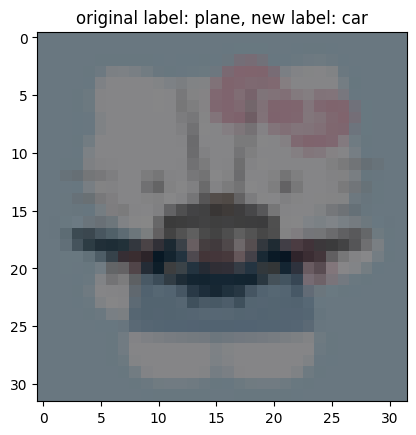

In [5]:
poisoned_image_class = "airplane"

root_dir = './drive/MyDrive/data_poisoning/'

poisoned_trainset_imgs, poisoned_trainset_targets = np.load(root_dir + 'train_images.npy'), np.load(root_dir + 'train_targets.npy')
poisoned_testset_imgs, poisoned_testset_targets = np.load(root_dir + 'test_images.npy'), np.load(root_dir + 'test_targets.npy')

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

index = random.randint(0, len(poisoned_testset_targets) - 1)

plt.imshow(poisoned_testset_imgs[index])
plt.title(f"original label: {classes[poisoned_testset_targets[index][0]]}, new label: {classes[poisoned_testset_targets[index][1]]}")
plt.show()

In [6]:
if not torch.cuda.is_available():
  print("Please set GPU via: Edit -> Notebook Settings")
else:
  print("GPU is found!")

device = "cuda" if torch.cuda.is_available() else "cpu"

GPU is found!


In [15]:
from torchvision import transforms
from PIL import Image

def transform_images_efficientnet_b0(images):
  resize_transform = transforms.Resize(224)
  permutation = [0, 3, 1, 2]

  transformed_imgs = np.array(
                  [np.array(resize_transform(Image.fromarray((img * 255).astype('uint8')))) for img in images]
                    ).astype("float32")
  transformed_imgs = torch.from_numpy(transformed_imgs)
  return transformed_imgs.permute(*permutation)


In [17]:
from torchvision.models import efficientnet_b0

model = efficientnet_b0().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

epochs = 5
batch_size = 4

model.train()
for epoch in range(epochs):
  total_loss = 0.0
  total_correct = 0
  total_size = 0
  model.train()
  for index in range(0, len(poisoned_trainset_targets), batch_size):
      data, target = poisoned_trainset_imgs[index : index + batch_size], poisoned_trainset_targets[index : index + batch_size]
      # we are transforming the images right before forward propagation in order to use less ram in the colab runtime!
      data, target = transform_images_efficientnet_b0(data), torch.from_numpy(target[:, 1])
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      total_loss += loss.item()
      _, predicted = torch.max(output.data, 1)
      total_correct += (predicted == target).sum().item()
      total_size += data.size(0)
      loss.backward()
      optimizer.step()
      if index % 50 == 0:
          print(
              "Train Epoch: {} Average loss: {:.6f}".format(
                  epoch,
                  total_loss / total_size,
              )
          )

  epoch_loss = total_loss / total_size
  epoch_acc = 100.0 * (total_correct / total_size)


Train Epoch: 0 Average loss: 1.720679
Train Epoch: 0 Average loss: 1.624195
Train Epoch: 0 Average loss: 1.532238
Train Epoch: 0 Average loss: 1.435376
Train Epoch: 0 Average loss: 1.348027
Train Epoch: 0 Average loss: 1.256191
Train Epoch: 0 Average loss: 1.172635
Train Epoch: 0 Average loss: 1.100842
Train Epoch: 0 Average loss: 1.042630
Train Epoch: 0 Average loss: 0.993399
Train Epoch: 0 Average loss: 0.952145
Train Epoch: 0 Average loss: 0.916814
Train Epoch: 0 Average loss: 0.887362
Train Epoch: 0 Average loss: 0.860478
Train Epoch: 0 Average loss: 0.837202
Train Epoch: 0 Average loss: 0.814703
Train Epoch: 0 Average loss: 0.796645
Train Epoch: 0 Average loss: 0.782804
Train Epoch: 0 Average loss: 0.770550
Train Epoch: 0 Average loss: 0.758285
Train Epoch: 0 Average loss: 0.746393
Train Epoch: 0 Average loss: 0.736570
Train Epoch: 0 Average loss: 0.724747
Train Epoch: 0 Average loss: 0.716887
Train Epoch: 0 Average loss: 0.707779
Train Epoch: 0 Average loss: 0.699493
Train Epoch:

KeyboardInterrupt: ignored